In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as multiproc
from joblib import Parallel, delayed
from numba import jit, njit, prange
import sympy as s
import inspect
from matplotlib.animation import FuncAnimation
from library import *
from matplotlib import cm
import matplotlib.colors
from functools import partial
import copy
import warnings
warnings.filterwarnings('ignore')


# Lorenz 84 model

In [2]:
R = 6.886
G = 1.347
a = 0.255
b = 4.0
parameters = [a,b,G,R]
lorenz_1 = particle_system(N=4, dt=0.01, num_steps=200,\
                           parameters = parameters, model_equations_1st_order = lorenz_84_equation, dimension = 3)

In [3]:
q_additional = lorenz_1.q[:,:,:2]

<IPython.core.display.Javascript object>


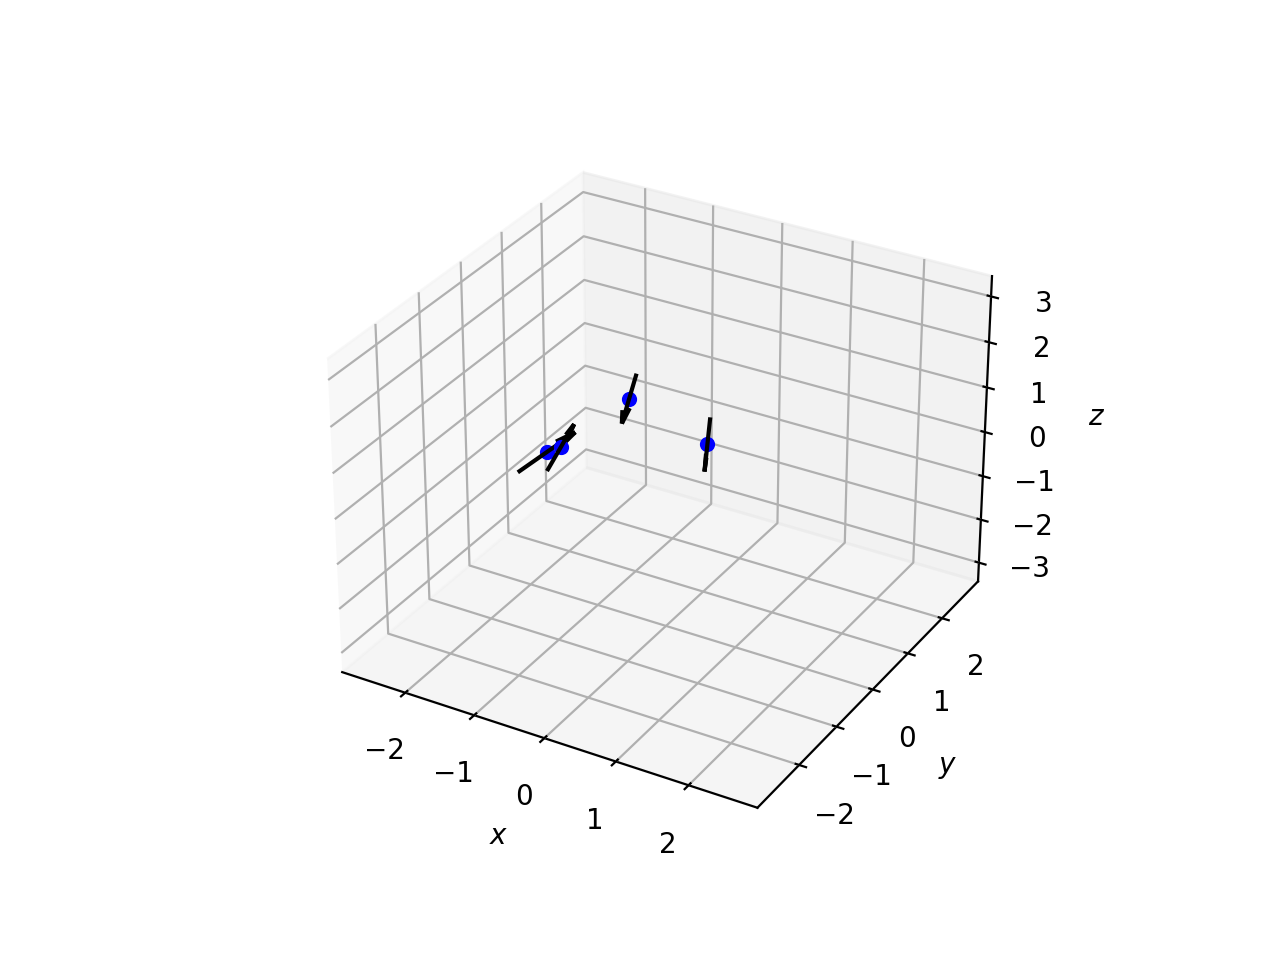

In [4]:
%matplotlib notebook
lorenz_1.animate(percentage_of_particles=1)


# Particle swarm model

## 2D

### homing

In [ ]:
m = 1.
K_r = 1.
K_a = 0.1
K_h = 2.
K_f = 20.
qh = 0.
s = 10.
r_r = 1.
r_a = 1.
r_p = 2.
K_p = 100.
swarm_homing = particle_system(N=30, dt=0.02, num_steps=20,\
                               parameters=[m,K_r,K_a,K_h,K_f,qh,s,r_r, r_a],\
                               model_equations_2nd_order = Swarm_homing , dimension = 2, sigmoid_activation=[200.,0.1])


In [ ]:
%matplotlib notebook
swarm_homing.animate()

### flock

In [5]:
m = 1.
C_a = 0.5
C_r = 1.
l_a = 2.
l_r = 0.5
alpha = 1.6
beta = 0.5
sawrm_2D = particle_system(N=30, dt=0.01, num_steps=30,\
                 parameters=[m,alpha,beta,C_r,C_a,l_r,l_a], model_equations_2nd_order = Swarm_eq , dimension = 2)


In [6]:
sawrm_2D.evolve_with_additional_particles(q_additional,force=force_1,force_type='attractive', num_steps=150)

<IPython.core.display.Javascript object>


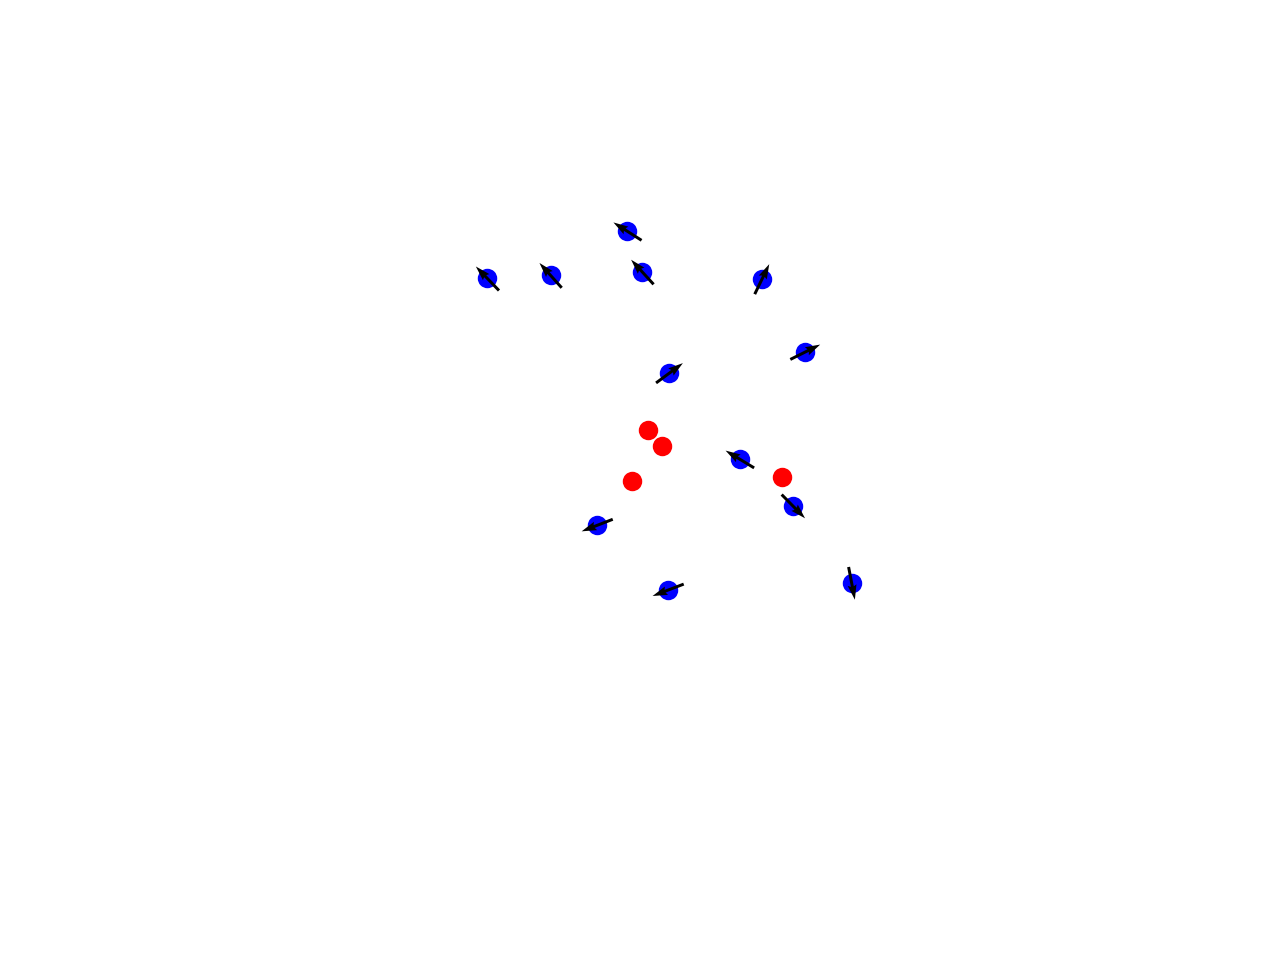

In [7]:
%matplotlib notebook
sawrm_2D.animate()

In [11]:
sawrm_2D.find_center_of_mass()

In [9]:
sawrm_2D.find_average_velocity()

In [10]:
sawrm_2D.enable_observation_layers(M=12)

In [14]:
sawrm_2D.layer_1
sawrm_2D.layer_2
sawrm_2D.layer_3
np.shape(sawrm_2D.layer_3)

(149, 12)

In [ ]:
%matplotlib notebook
sawrm_2D.animate(show_center_of_mass=True
                )

In [ ]:
sawrm_2D.find_densities(dx = .1)

In [ ]:
sawrm_2D.animate(show_density=True)

### ring

In [ ]:
m = 1.
alpha = 1.
beta = .5
C_r = 0.5
C_a = 1.
l_r = .5
l_a = 1.
sawrm_2D_ring = particle_system(N=20, dt=0.1, num_steps=200,\
                 parameters=[m,alpha,beta,C_r,C_a,l_r,l_a], model_equations_2nd_order = Swarm_eq , dimension = 2)

In [ ]:
sawrm_2D_ring.find_densities(dx = .5)

In [ ]:
%matplotlib notebook
sawrm_2D_ring.animate(show_density=True)

In [ ]:
sawrm_2D_ring.animate(show_density=False)

### clump

In [ ]:
m = 1.
alpha = 1.
beta = .5
C_r = 0.6
C_a = 1.
l_r = .5
l_a = 1.
sawrm_2D_clump = particle_system(N=70, dt=0.1, num_steps=200,\
                 parameters=[m,alpha,beta,C_r,C_a,l_r,l_a], model_equations_2nd_order = Swarm_eq , dimension = 2)

In [ ]:
sawrm_2D_clump.find_densities(dx = 0.1)

In [ ]:
%matplotlib notebook
sawrm_2D_clump.animate(show_density=True)

In [ ]:
m = 1.
alpha = .1
beta = 1.
C_r = .4
C_a = 1.3
l_r = 1.5
l_a = 1.
sawrm_2D = particle_system(N=70, dt=0.1, num_steps=200,\
                 parameters=[m,alpha,beta,C_r,C_a,l_r,l_a], model_equations = Swarm_eq , dimension = 2)

## 3D

In [ ]:
m = 1.
alpha = 1.
beta = 1.
C_r = .7
C_a = 1.
l_r = 2.
l_a = 1.
sawrm_3D = particle_system(N=40, dt=0.1, num_steps=200,\
                 parameters=[m,alpha,beta,C_r,C_a,l_r,l_a], model_equations = Swarm_eq , dimension = 3)
%matplotlib notebook
sawrm_3D.animate(arrow_length=5)


# Legacy code

In [ ]:
class particle_system():
    
    def __init__(self, N, dt, num_steps, parameters, model_equations_1st_order = None,\
                 model_equations_2nd_order = None, dimension = 3):
        
        # initilze parameters
        self.N = N
        self.dt = dt
        self.num_steps = num_steps
        self.parameters = parameters
        #self.model_equations = model_equations
        self.model_equations_1st_order = model_equations_1st_order
        self.model_equations_2nd_order = model_equations_2nd_order
        self.dimension = dimension
        
        # initilze N particles
        mu_q, sigma_p, mu_p, sigma_p = 1.,1.,1.,1.
        self.distribution_parameters = [mu_q, sigma_p, mu_p, sigma_p] 
        self.initilze_particles(dimension , self.distribution_parameters)
        
        # Initialize arrays to store trajectories
        self.q = np.array( [[[0.0 for _ in range(dimension)] for i in range(N)] for _ in range(1)])
        self.p = np.array( [[[0.0 for _ in range(dimension)] for i in range(N)] for _ in range(1)])
        
        # Set initial conditions
        self.q[0] = self.q_0
        self.p[0] = self.p_0 
        self.t = np.array([dt*i for i in range(num_steps)])
        # solve the system O.D.E.
        self.evolve(self.num_steps)
        # set up the system with no additional particles
        self.t_additional_0 = -1
        return
    
    def initilze_particles(self, dimension, distribution_parameters, method = 'normal'):
        self.q_0, self.p_0 = initilze_particles(self.N, dimension , method , distribution_parameters)
        return 
    
    def evolve(self, num_steps):
        """time evolve the system by the set parameters """
        N, dt, parameters, model_equations = self.N, self.dt,\
             self.parameters, self.model_equations
        q_0, p_0 = self.q[:,:][-1,:], self.p[:,:][-1,:]
        
        # first order ode, use runga kutta
        if len(inspect.signature(model_equations).parameters) == 3:
            q, p = runge_kutta_solver(parameters, model_equations, q_0 , dt, num_steps)
            self.q = np.concatenate((self.q, q[1:]), axis=0)
            self.p = np.concatenate((self.p, p[1:]), axis=0)
            
        elif len(inspect.signature(model_equations).parameters) == 4:
            q, p = verlet_solver(parameters, model_equations , p_0 , q_0, dt, num_steps)
            self.q = np.concatenate((self.q, q[1:]), axis=0)
            self.p = np.concatenate((self.p, p[1:]), axis=0)
            
    def find_densities(self, dx):
        dimension = self.dimension
        q = copy.copy(self.q)
        lim = np.max(np.abs(q[:, :, :]))
        num_steps = np.shape(q)[0]
        x_arr = np.linspace(-lim,lim,int(2*lim/dx))
        if dimension == 2:
            self.density = find_densities_(q, dimension, dx)
            self.X, self.Y = np.meshgrid(x_arr, x_arr)  
        elif dimension == 3:
            self.density = find_densities_(q, dimension, dx)
            self.X, self.Y, self.Z = np.meshgrid(x_arr, x_arr, x_arr) 
        elif dimension == 1:
            self.density = find_densities_(q, dimension, dx)
            self.X = x_arr
   
    
    def animate(self, show_density = False, percentage_of_particles = .4, arrow_length = 1):
        """produce an animation of the system,
        parameters: - percentage_of_particles to be shown in the animation"""
        if show_density:
            fig, ax = plt.subplots()  
            self.ax = ax
            def _forward(x):
                return np.exp(-x**2)
            def _inverse(x):
                return np.sqrt(np.log(x))
            
            divnorm = matplotlib.colors.FuncNorm((_forward, _inverse), vmin=.000, vmax=1)
            def animate_frame(i):
                ax.clear()
                ax.set_xlabel("x")
                ax.set_ylabel("y")
                contour_lines = ax.contour(self.Y, self.X, self.density[:, :, i], cmap='plasma')
                plt.clabel(contour_lines, inline=True, fontsize=8)
        else:
            # select particles to plot
            number_of_particles = self.q.shape[1]
            particles_to_plot = int(number_of_particles * percentage_of_particles)
            selected_particles = np.random.choice(number_of_particles, particles_to_plot, replace=False)
            # scale arrow length 
            q = self.q[:, selected_particles, :]
            p = self.p[:, selected_particles, :]
            norms = np.linalg.norm(p, axis=2, keepdims=True)
            safe_norms = np.where(norms > 1e-5, norms, np.ones_like(norms))
            p_scaled = np.divide(p, safe_norms, out=np.zeros_like(p), where=safe_norms > 1e-5) * arrow_length
            
            # create figure with correct projection
            if self.dimension == 3:
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')
            else:
                fig, ax = plt.subplots()  
            # get axis limits
            self.ax = ax
            if self.dimension == 3:
                xlim = np.max(np.abs(self.q[:, :, 0]))
                ylim = np.max(np.abs(self.q[:, :, 1]))
                zlim = np.max(np.abs(self.q[:, :, 2]))
                def animate_frame(i):
                    ax.clear()
                    ax.set_xlabel("$x$")
                    ax.set_ylabel(r'$y$')
                    ax.set_zlabel(r'$z$')
                    if self.t_additional_0 !=-1:
                        if i >self.t_additional_0:
                            for n in range(np.shape(self.q_additional)[1]):
                                ax.scatter(self.q_additional[:, n][i-self.t_additional_0, 0],\
                                           self.q_additional[:, n][i-self.t_additional_0, 1],\
                                           self.q_additional[:, n][i-self.t_additional_0, 2],color='r')
                    for n in range(len(selected_particles)):
                        ax.scatter(q[:, n][i, 0], q[:, n][i, 1],q[:, n][i, 2], color ='b')
                        ax.quiver(q[:, n][i, 0], q[:, n][i, 1],q[:, n][i, 2],\
                                  p_scaled[:, n][i, 0], p_scaled[:, n][i, 1],p_scaled[:, n][i, 2],\
                                  color='k', length=arrow_length, normalize=True,pivot='middle') 
                        
        
                    ax.set_xlim(-xlim, xlim)
                    ax.set_ylim(-ylim,ylim)
                    ax.set_zlim(-zlim, zlim)
                    
            elif self.dimension == 2:
                xlim = np.max(np.abs(self.q[:, :, 0]))*1.3
                ylim = np.max(np.abs(self.q[:, :, 1]))*1.3
                def animate_frame(i):
                    ax.clear()
                    ax.set_xlabel("$x$")
                    ax.set_ylabel(r'$y$')
                    if self.t_additional_0 !=-1:
                        if i >self.t_additional_0:
                            for n in range(np.shape(self.q_additional)[1]):
                                ax.scatter(self.q_additional[:, n][i-self.t_additional_0, 0],\
                                           self.q_additional[:, n][i-self.t_additional_0, 1], color='r')
                    for n in range(len(selected_particles)):
                        ax.scatter(q[:, n][i, 0], q[:, n][i, 1], color ='b')
                        ax.quiver(q[:, n][i, 0], q[:, n][i, 1],\
                                  p_scaled[:, n][i, 0], p_scaled[:, n][i, 1],\
                                  color='k', scale=6, scale_units='inches', angles='uv', pivot='mid',headwidth=3, width= .003) 
        
                    ax.set_xlim(-xlim, xlim)
                    ax.set_ylim(-ylim,ylim)
                    ax.axis('off') 
    
        self.ani = FuncAnimation(fig, animate_frame, frames=np.shape(self.q)[0], interval=self.dt, repeat=False)
        plt.show()
        
    def evolve_with_additional_particles(self, q_additional, force, force_type, num_steps = -1):
        # get system parameters
        N, dt, parameters, model_equations = self.N, self.dt, self.parameters, self.model_equations
        self.t_additional_0 = np.shape(self.q)[0]
        self.q_additional = q_additional
        
        # get the current state of the system
        q_0, p_0 = self.q[:,:][-1,:], self.p[:,:][-1,:]
        if num_steps == -1:
            num_steps = np.shape(q_additional)[0]
        
        # combine the system with the additional particles to calculate the total force
        if len(inspect.signature(model_equations).parameters) == 3:
            
            combined_system = lambda parameters, q, t: model_equations(parameters, p, q, t) + \
                              additional_particles_interaction(force, force_type, parameters, q, q_additional, t)
            q, p = runge_kutta_solver(parameters, combined_system, q_0 , dt, num_steps)
            self.q = np.concatenate((self.q, q[1:]), axis=0)
            self.p = np.concatenate((self.p, p[1:]), axis=0)
        elif len(inspect.signature(model_equations).parameters) == 4:
            combined_system = lambda parameters, p, q, t: model_equations(parameters, p, q,t) + \
                              additional_particles_interaction(force, force_type, parameters, q, q_additional, t)
            q, p = verlet_solver(parameters, combined_system , p_0 , q_0, dt, num_steps)
            self.q = np.concatenate((self.q, q[1:]), axis=0)
            self.p = np.concatenate((self.p, p[1:]), axis=0)
        # store the total system 
        
        return

In [ ]:
@njit(parallel=True)
def find_densities_(q, dimension, dx):
    lim = np.max(np.abs(q[:, :, :]))
    num_steps = np.shape(q)[0]
    x_arr = np.linspace(-lim,lim,int(2*lim/dx))
    
    if dimension == 2: 
        density_arr = np.zeros((int(2*lim/dx),int(2*lim/dx), num_steps))
        for i in prange(len(x_arr)):
            for j in prange(len(x_arr)):
                for t in prange(num_steps):
                        density_arr[i,j,t] = density(np.array([x_arr[i],x_arr[j]]), t, dx, q)
        return density_arr

    elif dimension == 3:
        density_arr = np.zeros((int(2*lim/dx),int(2*lim/dx), int(2*lim/dx), num_steps))
        for i in prange(len(x_arr)):
            for j in prange(len(x_arr)):
                for k in prange(len(x_arr)):
                    for t in prange(num_steps):
                        density_arr[i,j,k,t] = density(np.array([x_arr[i],x_arr[j],x_arr[k]]), t, dx, q)
        return density_arr

    elif dimension == 1:
        X = x_arr
        density_arr = np.zeros((int(2*lim/dx),int(2*lim/dx), num_steps))
        for i in range(len(x_arr)):
            for t in range(num_steps):
                density_arr[i,t] = density(x_arr[i], t, dx,q)
        return density_arr